<a href="https://colab.research.google.com/github/sb8919/Travelplus/blob/main/DL_model/BERT_%ED%83%9C%EA%B7%B8_%ED%8C%8C%EC%9D%BC2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
a=1

In [ ]:
# 패키지 다운로드
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# 주요 패키지 불러오기
import tensorflow as tf
import torch

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split

import pandas as pd
import folium
import numpy as np
import random
import time
import datetime

In [ ]:
# GPU 확인
n_devices = torch.cuda.device_count()
print(n_devices)

for i in range(n_devices):
    print(torch.cuda.get_device_name(i))

1
Tesla T4


-------------

In [ ]:
#구글드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 라벨링 파일 데이터 프레임 형태로 가져오기
import pandas as pd
df = pd.read_excel('/content/drive/MyDrive/labeling_data_0528.xlsx')

In [ ]:
# 인스타그램 본문 내용에서 특수문자 공백으로 교환
df["sentences"] = df["sentences"].str.replace(pat=r'[^\w]', repl=r' ', regex=True)

In [ ]:
# 인스타그램 태그 내용에서 특수문자 공백으로 교환
df["tags"] = df["tags"].str.replace(pat=r'[^\w]', repl=r' ', regex=True)

In [ ]:
# 10개의 데이터 랜덤으로 출력
df.sample(n=10)

,Unnamed: 0,sentences,tags,place,label
2312,2312,배달의민족 최 재 영 매니저만의 혜택 방문상담 빠른등록 추후관리...,화천삼대장 화천맛집 화천고기집 화천한우 화천닭갈비 화천카페 ...,NaN,8.0
354,354,두부는 여전히 인기 짱,배때기네하우스 반려동물동반여행 무섬마을 주택건축 전원주택 영주여...,경상북도영주시,1.0
1397,1397,겨울에 필수코스라는 원주 겨울여행 12곳 총정리 뷰좋고 분위기낭낭한 원주 겨울여...,원주겨울여행 원주여행 원주가볼만한곳 원주데이트 원주여행코스 원주...,NaN,3.0
1714,1714,지금 짚라인문경은 초록 이 넘실대는 뜨거운 여름 우리 귀염뽀짝 ZG들과 함께 짚라...,짚라인 문경 짚라인문경 문경짚라인 zipline mungyeon...,문경짚라인,5.0
3934,3934,양궁의 즐거움을 누리며 신화 기연을 이어가다,양궁 양궁장 기술 양궁너무재밌다 양궁 양궁선수,NaN,0.0
227,227,강원도 고성 속초 카페 추천 5 _h conte 피플님의 제보 강원도 ...,피플카트래블 피플카트래블_강원도,강원도,0.0
1102,1102,𝘀𝗹𝗲𝗱작년 아니고 이래뵈도 올해 1월최고 한파 였을 때 패딩 입은 모습 새롭네...,좋은자전거고르기 장갑챙기기 포천여행 산정호수썰매축제 겨울가족여행 ...,NaN,2.0
1187,1187,천북 청보리밭 충남 보령시 천북면 천광로 73 11 천북신흥교회 옆u200...,천북청보리밭 청보리밭 천북목장 천북굴 천북굴구이 천북굴찜 천...,천북면 (보령시),0.0
2290,2290,해수욕장이름이 뭐였지 고흥에 있는 해수욕장 발 담그다 옷은 다 젖고내강아지들...,고흥 고흥여행 고흥가볼만한곳,NaN,2.0
4542,4542,샤브샤브 생각날 때 늘 찾는 능동 능동칼국수 맛있는건 다 알겠지만 능동칼국수 등심 ...,동탄맛집 능동맛집 화성맛집 동탄칼국수 병점맛집 능동칼국수 맛...,NaN,8.0


In [ ]:
# label 열의 값 float-> str
df['label'] = df['label'].astype(str)

In [ ]:
# label 분류 숫자로 변경
df.loc[(df['label'] == "0.0"), 'label'] = 0  #0.0 => 스팸 => 0
df.loc[(df['label'] == "1.0"), 'label'] = 1  #1.0 => 가볼만한곳 => 1
df.loc[(df['label'] == "2.0"), 'label'] = 2  #2.0 => 가족여행 => 2
df.loc[(df['label'] == "3.0"), 'label'] = 3  #3.0 => 관람 => 3
df.loc[(df['label'] == "4.0"), 'label'] = 4  #4.0 => 맛집 => 4
df.loc[(df['label'] == "5.0"), 'label'] = 5  #5.0 => 우정여행 => 5
df.loc[(df['label'] == "6.0"), 'label'] = 6  #6.0 => 전통 => 6
df.loc[(df['label'] == "7.0"), 'label'] = 7  #7.0 => 체험 => 7
df.loc[(df['label'] == "8.0"), 'label'] = 8  #8.0 => 카페 => 8
df.loc[(df['label'] == "9.0"), 'label'] = 9  #9.0 => 캠핑 => 9

<Axes: >

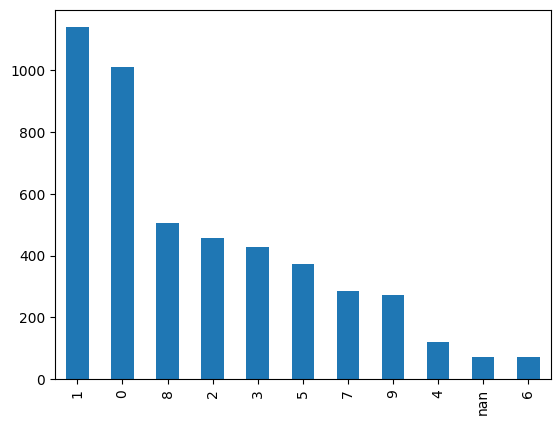

In [ ]:
# 데이터 정제하기
# label 값 분포 확인
df['label'].value_counts().plot(kind = 'bar')

In [ ]:
# 각 label 별 갯수 확인
df['label'].value_counts()

1      1139
0      1010
8       505
2       456
3       429
5       372
7       286
9       273
4       121
nan      73
6        73
Name: label, dtype: int64

In [ ]:
# Null 값 유무 확인 True <- Null 값 있음
print(df.isnull().values.any())

True


In [ ]:
# 어떤 열에서 Null 값 존재하는지 확인
print(df.isnull().sum())

Unnamed: 0       0
sentences        1
tags             0
place         2990
label            0
dtype: int64


In [ ]:
# Null 값 많은 place 열 제거
df = df.drop('place',axis=1)

In [ ]:
# 데이터 확인
df

,Unnamed: 0,sentences,tags,label
0,0,술이 달다 라고 하는걸 이걸보구 말하나봐요알쓰들도 무한대로 마실수 있는 연말을 ...,선릉 평상술집 술 술집 술안주 꿀주 꿀막걸리 막걸리 ...,8
1,1,,강남카페 강남대형카페도심 카즐_서울 카즐_강남 카즐_가로수길 카...,2
2,2,연타발 압구정 완전 대박인듯ㅜㅜ어느 하나 모자람없는 이 맛을 다양한 세계로 이끌어가...,도산공원맛집 연타발압구정본점 강남맛집 신사동맛집 압구정맛집 도산...,1
3,3,날 풀리면 가기 좋을 서울 테라스카페 모음집 뷰맛집으로 너무 핫한 서울 예쁜...,서울카페 서울카페추천 서울데이트 서울데이트코스 서울가볼만한곳 ...,9
4,4,가장 행복한 순간 배꼽집에서 고기 먹을 때 맛있게 구워서 한 점 한 점 먹으면 ...,배꼽집 강남맛집 삼성동맛집 삼성역맛집 봉은사역맛집 코엑스맛집 ...,8
...,...,...,...,...
4732,4732,올드카에 관심 있다면 규슈 자동차 박물관2023 03 08,사진 여행사진 일본 여행 유후인 일본여행 후쿠오카 규슈 ...,7
4733,4733,조선의 외교관 역관 부산박물관 특별기획전 전시관람하고 왔어요 아직 어린 아들...,부산박물관 특별기획전 전시관람 전시연출 박물관 포토스팟 역관...,7
4734,4734,어벤져스 엔드게임의 감동을 다시 한 번 피규어뮤지엄제주 2023 03 15,사진 여행사진 한국 제주 여행 풍경 한국여행 제주도 ...,7
4735,4735,사 한국박물관협회 회장 조한희 는 지난 5월 11일 목 부터 13일 토 까지 3일...,한국박물관협회 한박협 뮤지엄 박물관 미술관 제17회한국박물관국제...,0


In [ ]:
# 어떤 열에서 Null 값 존재하는지 확인
print(df.isnull().sum())

Unnamed: 0    0
sentences     1
tags          0
label         0
dtype: int64


In [ ]:
# Null값 제거
df = df.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(df.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [ ]:
# Null값 제거 후 데이터 개수 확인
print(len(df))

4736


1      1139
0      1010
8       505
2       456
3       429
5       371
7       286
9       273
4       121
nan      73
6        73
Name: label, dtype: int64


4736

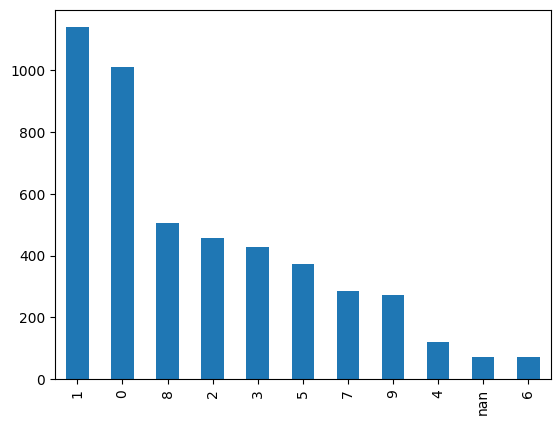

In [ ]:
# Null값 제거 후 각 label별 갯수 확인
df['label'].value_counts().plot(kind = 'bar')
print(df['label'].value_counts())
len(df)

In [ ]:
# label에서 nan 제거
df = df[df.label != 'nan']

1    1139
0    1010
8     505
2     456
3     429
5     371
7     286
9     273
4     121
6      73
Name: label, dtype: int64


4663

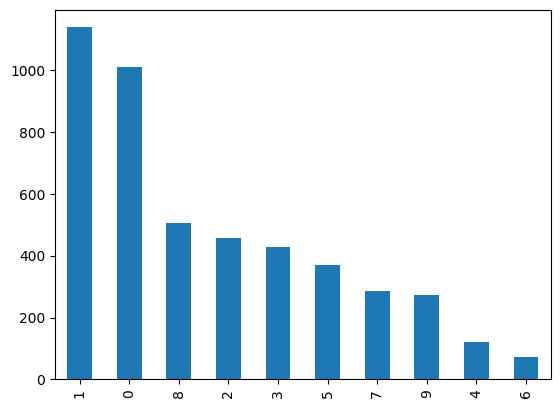

In [ ]:
# 각 label별 갯수 확인
df['label'].value_counts().plot(kind = 'bar')
print(df['label'].value_counts())
len(df)

In [ ]:
# data_list에 본문과 라벨링된 값 저장
data_list = []
for q, label in zip(df['tags'], df['label'])  :
    if q.strip() == '' or q.strip() == '.':
        print(q)
        continue
    data = []
    data.append(q)
    data.append(str(label))

    data_list.append(data)

In [ ]:
print(data_list[0])
print(data_list[500])
#print(data_list[1200])
# print(data_list[1800])
# print(data_list[2400])
# print(data_list[2800])
# print(data_list[-1])

[' 선릉   평상술집   술   술집   술안주   꿀주   꿀막걸리   막걸리   선릉맛집   선릉술집   강남술집', '8']
[' 강원도고성여행   고성DMZ역사여행   DMZTHE   강원도철원여행   철원레저스포츠여행   DMZTHE   DMZTHEGANGWON   강원DMZ   생태평화벨트   한반도생태평화벨트   고성여행   고성DMZ   고성역사여행   고성데이트코스   고성커플여행   고성가볼만한곳   서울근처드라이브코스   고성추천관광지   고성통일전망대   주말여행', '3']


In [ ]:
#train & test 데이터로 나누기 train 80 test 20
from sklearn.model_selection import train_test_split
                                                         
train, test = train_test_split(df, test_size=0.2, random_state=0)

In [ ]:
# train data, test data 개수 확인
print(len(train))
print(len(test))

3730
933


In [ ]:
print(train)

      Unnamed: 0                                          sentences  \
4391        4391                 짜릿함 느낄 수 있는 이색 해외 액티비티 BEST 7입니다     
2676        2676  족발신선생 영등포점에서만맛 볼 수 있는 화덕족발   600 의 화산석 화덕으로매장에...   
2205        2205                                  나종이 푹 쉬고 올게 안뇽      
2533        2533              _____소문듣고 왔는데 정말 맛있다  진심 단골이 될 것 같다     
4282        4282                                       U0001f90d      
...          ...                                                ...   
1050        1050   해파랑길 32코스를 걷다   맹방해변에서 추암해변까지 긴 거리지만 아름다운 오십천...   
3320        3320  오늘 소개시켜드릴 곳은 바로 청와옥 을지로3가직영점 든든한 국밥 한그릇이 최고죠  ...   
1683        1683          보더콜리 댕댕이처럼 기분좋은 주말입니다카페공간비 놀러온 보더콜리댕댕이      
2660        2660   영등포 타임스퀘어 데이트 핫플 모음집  맛집부터 카페  실내동물원  공방까지 다 ...   
2785        2785  부산근교 마운틴뷰 카페 리스트  오션뷰도 예쁘지만 마운틴뷰도 넘 예쁘다구   초록초...   

                                                   tags label  
4391   해외 여행   미안하다여행가자   미안행_해외   해외여행   해외액티비티   액...     0  
2676   족발신선생영등포점   

------

문장별 전처리

In [ ]:
# CLS, SEP 붙이기 (문장의 시작, 끝)
document_bert = ["[CLS] " + str(s) + " [SEP]" for s in train.tags]

In [ ]:
document_bert[:5]

['[CLS]  해외 여행   미안하다여행가자   미안행_해외   해외여행   해외액티비티   액티비티추천   겨울액티비티   해외가볼만한곳   벌룬투어   스카이다이빙   두바이여행   두바이가볼만한곳   센토사섬   루지체험   번지점프   이색액티비티   이색여행   이색해외여행   해외여행지   해외여행지추천   해외여행준비   해외핫플   두바이사파리   시드니여행   좋아요반사   좋반   소통   여행에미치다   여행스타그램   여행 [SEP]',
 '[CLS]  족발신선생영등포점   족신영등포   영등포맛집   영등포역맛집   영등포족발   영등포역족발   맛집   맛집인정   영등포가볼만한곳   영등포역모임   영등포맛집추천   먹스타맞팔   영등포술집   먹방로드   영등포역족발맛집   맞팔해요   프로먹방러 [SEP]',
 '[CLS]  공주휴가   daily   l4likes [SEP]',
 '[CLS]  미도인   부평미도인   부평400등심스테이크덮밥   인천라이프   인천파스타   부평맛집미도인   양식집   부평맛집   경양식   인천숨은맛집   인생식탁   인천맛집   부평가볼만한곳   부평파스타 [SEP]',
 '[CLS]  친구   지하철드라이브    여행   데일리   daily   사진   일반카메라   아이폰12미니   라이브   즐거움   추억   사진겁나많아   91년생   ootd   instadaily   insta   selfie   일상   전시회   무쌍   짝눈   서울   나들이   노을   망원한강   플라워바이네이키드홍대   홍대코코넛박스 [SEP]']

In [ ]:
#사전 학습된 BERT multilingual 모델 내 포함되어있는 토크나이저 활용
print('tokenizeing..')
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased',do_lower_case=False)
tokenized_texts = [ tokenizer.tokenize(s) for s in document_bert]
print('tokenized_texts[0]:',tokenized_texts[0])

tokenizeing..
tokenized_texts[0]: ['[CLS]', '해', '##외', '여', '##행', '미', '##안', '##하다', '##여', '##행', '##가', '##자', '미', '##안', '##행', '_', '해', '##외', '해', '##외', '##여', '##행', '해', '##외', '##액', '##티', '##비', '##티', '액', '##티', '##비', '##티', '##추', '##천', '겨', '##울', '##액', '##티', '##비', '##티', '해', '##외', '##가', '##볼', '##만', '##한', '##곳', '벌', '##룬', '##투', '##어', '스', '##카', '##이다', '##이', '##빙', '두', '##바', '##이', '##여', '##행', '두', '##바', '##이가', '##볼', '##만', '##한', '##곳', '센', '##토', '##사', '##섬', '루', '##지', '##체', '##험', '번', '##지', '##점', '##프', '이', '##색', '##액', '##티', '##비', '##티', '이', '##색', '##여', '##행', '이', '##색', '##해', '##외', '##여', '##행', '해', '##외', '##여', '##행', '##지', '해', '##외', '##여', '##행', '##지', '##추', '##천', '해', '##외', '##여', '##행', '##준', '##비', '해', '##외', '##핫', '##플', '두', '##바', '##이', '##사', '##파', '##리', '시', '##드', '##니', '##여', '##행', '좋', '##아', '##요', '##반', '##사', '좋', '##반', '소', '##통', '여', '##행', '##에', '##미', '##치', '##다', '여', '##행', '#

In [ ]:
#token들의 max length보다 크게 MAX_LEN을 설정한다. 설정한 MAX_LEN만큼 빈 공간을 0 이 채운다
print('padding')
MAX_LEN = 128
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen = MAX_LEN, dtype='long', truncating='post', padding='post')
input_ids[0]
print('input_ids[0]:',input_ids[0])

padding
input_ids[0]: [   101   9960  78705   9565  25549   9309  34951  32679  29935  25549
  11287  13764   9309  34951  25549    168   9960  78705   9960  78705
  29935  25549   9960  78705 119122  45725  29455  45725   9533  45725
  29455  45725 119274  38631   8877  78123 119122  45725  29455  45725
   9960  78705  11287 101450  19105  11102 118644   9339 118890  75855
  12965   9477  24206  11925  10739 119005   9102  42144  10739  29935
  25549   9102  42144  57362 101450  19105  11102 118644   9437  26444
  12945 119040   9213  12508  29683  86834   9338  12508  34907  28396
   9638  41442 119122  45725  29455  45725   9638  41442  29935  25549
   9638  41442  14523  78705  29935  25549   9960  78705  29935  25549
  12508   9960  78705  29935  25549  12508 119274  38631   9960  78705
  29935  25549  54867  29455   9960  78705 119419 119412   9102  42144
  10739  12945  46150  12692   9485  15001  25503  29935]


In [ ]:
#학습 속도를 높이기 위해 실 데이터가 있는 곳과 padding이 있는곳을 attention에게 알려줌

attention_masks = []

for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

print('attention_masks[0]:',attention_masks[0])

attention_masks[0]: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [ ]:
# input 과 mask가 뒤섞이지 않도록 random_state를 일정하게 고정.
# test set은 위에서 분리되었기에 , train 과 validation set만 분리
print('split train - val')
train_inputs, validation_inputs, train_labels, validation_labels = \
train_test_split(input_ids, train['label'].values, random_state=42, test_size=0.1)

train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=42,test_size=0.1)

split train - val


In [ ]:
train_labels = train_labels.astype(int)

In [ ]:
validation_labels = validation_labels.astype(int)

In [ ]:
# numpy ndarray로 되어있는 input,lable,mask들을 torch tensor로 변환
print('convert data to tenser..')
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

convert data to tenser..


In [ ]:
#현재 쓰고있는 GPU의 VRAM에 맞게 배치사이즈 설정(크게 설정후 부족메시지가 뜨면 8의 배수중 작은것으로 줄여나가기)
print('set batch and data loader')
BATCH_SIZE = 80

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = BATCH_SIZE)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=BATCH_SIZE)

set batch and data loader


In [ ]:
#위의 train-val 셋 전처리와 동일
print('data split')
sentences = test['tags']
sentences = ["[CLS]"+str(sentence)+"[SEP]" for sentence in sentences]
labels = test['label'].values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

attention_masks = []
for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

labels = labels.astype(int)

test_inputs = torch.tensor(input_ids)
test_labels = torch.tensor(labels)
test_masks = torch.tensor(attention_masks)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)

data split


In [ ]:
import torch

print(torch.cuda.is_available())  # CUDA를 사용할 수 있는지 확인
print(torch.cuda.device_count())  # 사용 가능한 CUDA 디바이스 개수 확인

for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))  # CUDA 디바이스 이름 출력


True
1
Tesla T4


In [ ]:
#GPU 체크 및 할당
if torch.cuda.is_available():    
    device = torch.device("cuda:0")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')


## 분류를 위한 BERT 모델 생성
# transformers 의 BertForSequenceClassification 모듈 이용
print('making BERT model for classification')
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=10)
#model.cuda()
model.to(device)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
making BERT model for classification


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [ ]:
# transformers에서 제공하는 옵티마이저 중 AdamW를 사용
# 총 훈련 스텝은 이터레이션 * 에폭 수로 설정
# 러닝 레잇 스케쥴러도 transformers에서 제공하는것을 사용

#옵티마이저 설정
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # 학습률
                  eps = 1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값
                )

# 에폭수
epochs = 50

# 총 훈련 스텝
total_steps = len(train_dataloader) * epochs

# lr 조금씩 감소시키는 스케줄러
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

##학습
# accuracy 와 시간 표시함수 정의
# 정확도 계산 함수
print('train start')
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# 시간 표시 함수
def format_time(elapsed):
    # 반올림
    elapsed_rounded = int(round((elapsed)))
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

train start


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# 데이터로더에서 배치만큼 가져온 후 forward, backward pass를 수행
# gradient update는 명시적으로 하지 않고 위에서 로드한 optimizer를 활용
# 재현을 위해 랜덤시드 고정
# 모든 Epoch를 학습하면 학습이 종료

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# 그래디언트 초기화
model.zero_grad()

# 에폭만큼 반복
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 시작 시간 설정
    t0 = time.time()

    # 로스 초기화
    total_loss = 0

    # 훈련모드로 변경
    model.train()
        
    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):
        # 경과 정보 표시
        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch

        # Forward 수행                
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        
        # 로스 구함
        loss = outputs[0]

        # 총 로스 계산
        total_loss += loss.item()

        # Backward 수행으로 그래디언트 계산
        loss.backward()

        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        # 스케줄러로 학습률 감소
        scheduler.step()

        # 그래디언트 초기화
        model.zero_grad()

    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)            

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    #시작 시간 설정
    t0 = time.time()

    # 평가모드로 변경
    model.eval()

    # 변수 초기화
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in validation_dataloader:
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch
        
        # 그래디언트 계산 안함
        with torch.no_grad():     
            # Forward 수행
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # 로스 구함
        logits = outputs[0]

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # 출력 로짓과 라벨을 비교하여 정확도 계산
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")
print("")


======== Epoch 1 / 50 ========
Training...

  Average training loss: 1.98
  Training epcoh took: 0:01:12

Running Validation...
  Accuracy: 0.44
  Validation took: 0:00:03

======== Epoch 2 / 50 ========
Training...

  Average training loss: 1.68
  Training epcoh took: 0:01:11

Running Validation...
  Accuracy: 0.44
  Validation took: 0:00:03

======== Epoch 3 / 50 ========
Training...

  Average training loss: 1.53
  Training epcoh took: 0:01:11

Running Validation...
  Accuracy: 0.43
  Validation took: 0:00:03

======== Epoch 4 / 50 ========
Training...

  Average training loss: 1.39
  Training epcoh took: 0:01:11

Running Validation...
  Accuracy: 0.41
  Validation took: 0:00:03

======== Epoch 5 / 50 ========
Training...

  Average training loss: 1.26
  Training epcoh took: 0:01:11

Running Validation...
  Accuracy: 0.46
  Validation took: 0:00:03

======== Epoch 6 / 50 ========
Training...

  Average training loss: 1.14
  Training epcoh took: 0:01:11

Running Validation...
  Accu

In [ ]:
print('test start')
#시작 시간 설정
t0 = time.time()

# 평가모드로 변경
model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_dataloader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)
    
    # 배치에서 데이터 추출
    b_input_ids, b_input_mask, b_labels = batch
    
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))
print("test finished!")

test start

Accuracy: 0.44
Test took: 0:00:07
test finished!
